<a href="https://colab.research.google.com/github/mkash96/RLA2/blob/main/RLASSI2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PART 1

In [ ]:
# Setting up the grid

import numpy as np
import matplotlib.pyplot as plt


# Gridworld parameters
grid_size = 5
gamma = 0.95
states = [(i, j) for i in range(grid_size) for j in range(grid_size)]
actions = ['up', 'down', 'left', 'right']
action_prob = 0.25  # Equal probability for each action
transitions = {}

# Reward and transition setups
rewards = np.zeros((grid_size, grid_size))
transitions = {}

for i in range(grid_size):
    for j in range(grid_size):
        transitions[(i, j)] = {}
        for action in actions:
            if action == 'up':
                next_state = (max(i-1, 0), j)
            elif action == 'down':
                next_state = (min(i+1, grid_size-1), j)
            elif action == 'left':
                next_state = (i, max(j-1, 0))
            elif action == 'right':
                next_state = (i, min(j+1, grid_size-1))
            if (i, j) == (0, 1):  # Blue square
                transitions[(i, j)][action] = [(3, 2)], 5  # Red square
            elif (i, j) == (0, 4):  # Green square
                transitions[(i, j)][action] = [(3, 2), (4, 4)], 2.5  # Red or Yellow square
            elif (i, j) == next_state:
                transitions[(i, j)][action] = [next_state], -0.5
            else:
                transitions[(i, j)][action] = [next_state], 0

# Define the reward function
def reward(state, action):
    if state in special_states:
        return special_states[state][1]
    return 0

**1. (1) Solving the system of Bellman equations explicitly**

In [ ]:
def solve_bellman_system(states, transitions, discount=0.95):
    num_states = len(states)
    matrix_A = np.zeros((num_states, num_states))
    vector_b = np.zeros(num_states)

    for state_index, current_state in enumerate(states):
        matrix_A[state_index, state_index] = 1  # Set diagonal element to 1
        for move in actions:
            future_states, reward = transitions[current_state][move]
            if isinstance(future_states, list):  # Check if there's a list of future states
                probability = 1 / len(future_states)  # Equal probability distribution
                for next_state in future_states:
                    next_state_index = states.index(next_state)
                    matrix_A[state_index, next_state_index] -= probability * discount / 4
                    vector_b[state_index] += probability * reward / 4
            else:
                next_state_index = states.index(future_states[0])
                matrix_A[state_index, next_state_index] -= discount / 4
                vector_b[state_index] += reward / 4

    value_vector = np.linalg.solve(matrix_A, vector_b)
    return value_vector.reshape((grid_size, grid_size))

value_function1 = solve_bellman_system(states, transitions)
print("Grid Values: ")
for line in value_function1:
    print(" ".join(f"{val:7.2f}" for val in line))

Grid Values: 
   2.17    4.73    2.07    1.27    1.78
   1.12    1.78    1.17    0.74    0.56
   0.16    0.48    0.35    0.11   -0.19
  -0.55   -0.28   -0.28   -0.44   -0.74
  -1.11   -0.85   -0.81   -0.94   -1.24


**1. (2) Iterative policy evaluation**



In [ ]:
def policy_evaluation(states, transitions, discount_factor=0.95, convergence_threshold=0.01):
    value_grid = np.zeros((grid_size, grid_size))

    while True:
        max_change = 0
        for current_state in states:
            old_value = value_grid[current_state]
            value_grid[current_state] = 0
            for move in actions:
                subsequent_states, reward = transitions[current_state][move]
                if isinstance(subsequent_states, list):  # Handle multiple subsequent states
                    expected_val = sum(value_grid[s] for s in subsequent_states) / len(subsequent_states)
                    value_grid[current_state] += 0.25 * (reward + discount_factor * expected_val)
                elif subsequent_states is None:
                    value_grid[current_state] += 0.25 * reward  # Equal probability for each action
                else:
                    value_grid[current_state] += 0.25 * (reward + discount_factor * value_grid[subsequent_states])
            max_change = max(max_change, abs(old_value - value_grid[current_state]))
        if max_change < convergence_threshold:
            break
    return value_grid

value_function2 = policy_evaluation(states, transitions)
print("Grid Values: ")
for line in value_function2:
    print(" ".join(f"{val:7.2f}" for val in line))


Grid Values: 
   1.11    5.05    1.56    0.97    2.31
   0.65    1.74    1.07    0.75    0.82
   0.14    0.57    0.48    0.31    0.14
  -0.20    0.03    0.05   -0.04   -0.23
  -0.42   -0.27   -0.25   -0.30   -0.45


**1. (3) Value Iteration**

In [ ]:
def value_iteration(states, transitions, gamma=0.95, theta=0.01):
    V = np.zeros((grid_size, grid_size))  # Initialize the value function
    delta = float('inf')

    while delta > theta:
        delta = 0
        new_V = np.copy(V)  # Create a copy of V to store updated values

        for state in states:
            old_value = V[state]
            action_values = []

            for action in actions:
                next_states, reward = transitions[state][action]

                if isinstance(next_states, list):  # If there are multiple possible next states
                    avg_value = 0.5
                    for ns in next_states:
                        avg_value += reward + gamma * V[ns]  # Compute value for each next state
                    avg_value /= len(next_states)  # Compute the average value
                    action_values.append(avg_value)
                else:  # If there is a single next state
                    action_values.append(reward + gamma * V[next_states])

            new_V[state] = max(action_values)  # Update the value function
            delta = max(delta, abs(old_value - new_V[state]))

        V = new_V  # Update V with the new values

    return V

value_function3 = value_iteration(states, transitions)
print("Grid Values: ")
for line in value_function3:
    print(" ".join(f"{val:7.2f}" for val in line))



Grid Values: 
  30.95   32.05   30.95   29.90   28.08
  29.90   30.95   29.90   28.90   27.96
  28.90   29.90   28.90   27.96   27.05
  27.96   28.90   27.96   27.05   26.20
  27.05   27.96   27.05   26.20   25.39


**1. Visualization**

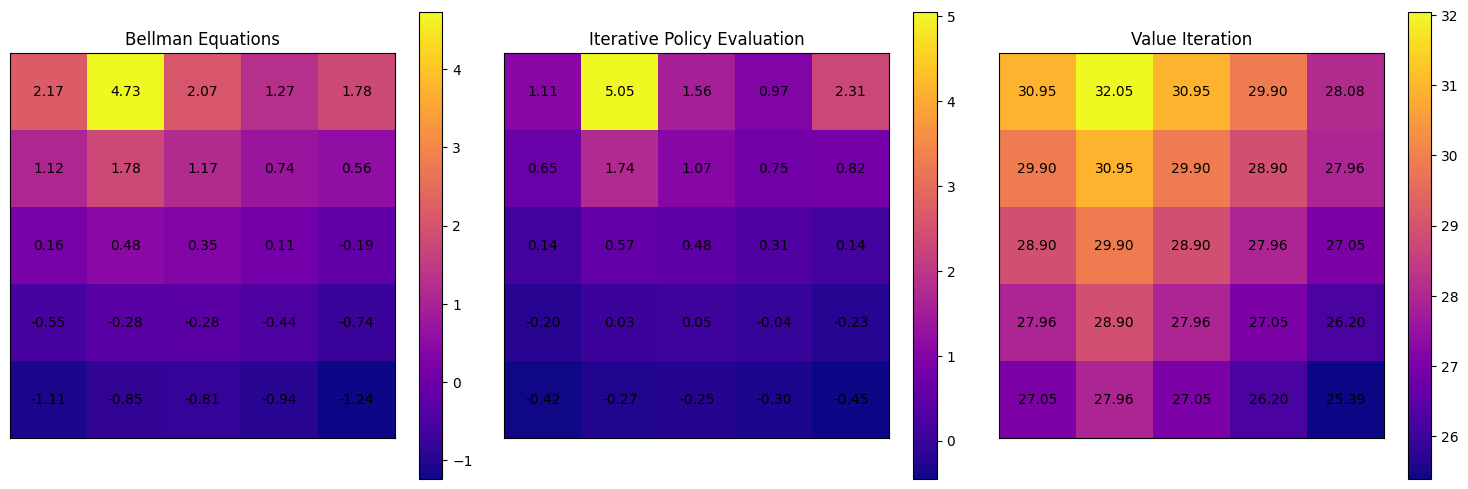

In [ ]:
def plot_value_function(ax, values, title):
    cax = ax.imshow(values, cmap='plasma')
    for (i, j), val in np.ndenumerate(values):
        ax.text(j, i, f'{val:.2f}', ha='center', va='center', color='black')
    ax.set_title(title)
    ax.set_xticks([])
    ax.set_yticks([])
    return cax

# Create a figure with subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot each grid with the new plot function
cax1 = plot_value_function(axes[0], value_function1, 'Bellman Equations')
cax2 = plot_value_function(axes[1], value_function2, 'Iterative Policy Evaluation')
cax3 = plot_value_function(axes[2], value_function3, 'Value Iteration')

# Add colorbars to each subplot
fig.colorbar(cax1, ax=axes[0])
fig.colorbar(cax2, ax=axes[1])
fig.colorbar(cax3, ax=axes[2])

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

**2. (1) Explicitly solving the Bellman optimality equation**


In [ ]:
def calculate_action_value(state, action, transitions, V, gamma):
    next_states, reward = transitions[state][action]
    if len(next_states) > 1:
        expected_value = sum(V[ns] for ns in next_states) / len(next_states)
    else:
        expected_value = V[next_states[0]]
    return reward + gamma * expected_value

def derive_optimal_policy(states, transitions, V, gamma=0.95):
    policy = np.empty((grid_size, grid_size), dtype=object)

    for state in states:
        best_action = None
        highest_value = float('-inf')

        for action in actions:
            action_value = calculate_action_value(state, action, transitions, V, gamma)

            if action_value > highest_value:
                highest_value = action_value
                best_action = action

        policy[state] = best_action

    return policy

# Define states and transitions appropriately
states = [(i, j) for i in range(grid_size) for j in range(grid_size)]

# Derive the optimal policy using the revised function
optimal_policy = derive_optimal_policy(states, transitions, value_function1)
print(optimal_policy)


[['right' 'up' 'left' 'left' 'up']
 ['up' 'up' 'up' 'up' 'up']
 ['up' 'up' 'up' 'up' 'up']
 ['up' 'up' 'up' 'up' 'up']
 ['up' 'up' 'up' 'up' 'up']]


**2. (2) Policy iteration with iterative policy evaluation**


In [ ]:
def evaluate_policy(states, transitions, policy, gamma=0.95, theta=0.01):
    value_function = np.zeros((grid_size, grid_size))
    max_change = float('inf')

    while max_change > theta:
        max_change = 0
        for state in states:
            if not (0 <= state[0] < grid_size and 0 <= state[0] < grid_size):
                continue  # Skip invalid states

            current_value = value_function[state]
            new_value = 0
            for action in actions:
                if action not in transitions[state]:
                    continue  # Skip invalid actions

                next_states, reward = transitions[state][action]
                if isinstance(next_states, list):  # Multiple next states
                    avg_next_value = 0
                    for ns in next_states:
                        if (0 <= ns[0] < grid_size and 0 <= ns[1] < grid_size):
                            avg_next_value += value_function[ns]
                    avg_next_value /= len(next_states)
                    new_value += 0.25 * (reward + gamma * avg_next_value)
                else:  # Single next state
                    ns = next_states
                    if (0 <= ns[0] < grid_size and 0 <= ns[1] < grid_size):
                        new_value += 0.25 * (reward + gamma * value_function[ns])

            value_function[state] = new_value
            max_change = max(max_change, abs(current_value - value_function[state]))

    return value_function

def improve_policy(states, transitions, gamma=0.95):
    policy = np.random.choice(actions, size=(grid_size, grid_size))
    is_stable = False

    while not is_stable:
        # Evaluate current policy
        value_function = evaluate_policy(states, transitions, policy, gamma)
        is_stable = True

        # Improve policy
        for state in states:
            if not (0 <= state[0] < grid_size and 0 <= state[0] < grid_size):
                continue  # Skip invalid states

            previous_action = policy[state]
            best_action = None
            highest_value = -float('inf')

            for action in actions:
                if action not in transitions[state]:
                    continue  # Skip invalid actions

                next_states, reward = transitions[state][action]
                expected_value = 0
                if isinstance(next_states, list):  # Multiple next states
                    for ns in next_states:
                        if (0 <= ns[0] < grid_size and 0 <= ns[1] < grid_size):
                            prob = 1 / len(next_states)
                            expected_value += prob * (reward + gamma * value_function[ns])
                else:  # Single next state
                    ns = next_states

                    if (0 <= ns[0] < grid_size and 0 <= ns[1] < grid_size):
                        prob = 1
                        expected_value += prob * (reward + gamma * value_function[ns])

                if expected_value > highest_value:
                    highest_value = expected_value
                    best_action = action

            policy[state] = best_action
            if previous_action != best_action:
                is_stable = False


    return policy, value_function

optimal_policy, optimal_values = improve_policy(states, transitions)
print(optimal_policy)

[['right' 'up' 'left' 'left' 'up']
 ['up' 'up' 'up' 'up' 'up']
 ['up' 'up' 'up' 'up' 'up']
 ['up' 'up' 'up' 'up' 'up']
 ['up' 'up' 'up' 'up' 'up']]


**2. (3) Policy improvement with value iteration**


In [ ]:
def value_iteration(states, transitions, gamma=0.95, theta=0.01):
    # Initialize value function and policy
    value_function = np.zeros((grid_size, grid_size))
    optimal_policy = np.full((grid_size, grid_size), None, dtype=object)

    while True:
        max_delta = 0
        for state in states:
            if not (0 <= state[0] < grid_size and 0 <= state[1] < grid_size):
                continue  # Skip invalid states

            old_value = value_function[state]
            action_values = []

            for action in actions:
                if action not in transitions[state]:
                    continue  # Skip invalid actions

                next_states, reward = transitions[state][action]
                expected_value = 0
                for ns in next_states:
                    if (0 <= ns[0] < grid_size and 0 <= ns[1] < grid_size):
                        prob = 1 / len(next_states)
                        expected_value += prob * (reward + gamma * value_function[ns])

                action_values.append((expected_value, action))

            # Select the best action and update value
            best_value, best_action = max(action_values, key=lambda x: x[0])
            value_function[state] = best_value
            optimal_policy[state] = best_action

            # Update delta for convergence check
            max_delta = max(max_delta, abs(old_value - best_value))

        if max_delta < theta:
            break

    return optimal_policy, value_function


optimal_policy, optimal_values = value_iteration(states, transitions)
print("Optimal Policy:")
print(np.array(optimal_policy).reshape((grid_size, grid_size)))


Optimal Policy:
[['right' 'up' 'left' 'left' 'up']
 ['up' 'up' 'up' 'up' 'left']
 ['up' 'up' 'up' 'up' 'up']
 ['up' 'up' 'up' 'up' 'up']
 ['up' 'up' 'up' 'up' 'up']]


# PART 2

In [ ]:
# Define grid dimensions and terminal states
grid_size = 5
terminal_states = [(2, 4), (4, 0), (3, 3)]  # Define terminal states

# Initialize rewards and transitions
rewards = np.full((grid_size, grid_size), -0.2)  # Default reward for any movement
transitions = {}

for i in range(grid_size):
    for j in range(grid_size):
        transitions[(i, j)] = {}
        if (i, j) in terminal_states:
            for action in ['up', 'down', 'left', 'right']:
                transitions[(i, j)][action] = ((i, j), 0)  # Terminal state transitions to itself with 0 reward
        else:
            for action in ['up', 'down', 'left', 'right']:
                if action == 'up':
                    next_state = (max(i-1, 0), j)
                elif action == 'down':
                    next_state = (min(i+1, grid_size-1), j)
                elif action == 'left':
                    next_state = (i, max(j-1, 0))
                elif action == 'right':
                    next_state = (i, min(j+1, grid_size-1))

                # Handle special states
                if (i, j) == (0, 1):  # Blue square
                    transitions[(i, j)][action] = [(3, 2)], 5  # Jump to Red square
                elif (i, j) == (0, 4):  # Green square
                    transitions[(i, j)][action] = [(3, 2), (4, 4)], 2.5  # Jump to Red or Yellow square
                # Handle all other states
                else:
                    if next_state in terminal_states:
                        transitions[(i, j)][action] = [next_state], 0
                    elif (i, j) == next_state:  # Edge of the grid, moves back to itself
                        transitions[(i, j)][action] = [next_state], -0.2
                    else:
                        transitions[(i, j)][action] = [next_state], rewards[next_state]

def is_terminal(state):
    return state in terminal_states

def get_next_state(state, action):
    i, j = state
    if action == 'up':
        return (max(i-1, 0), j)
    elif action == 'down':
        return (min(i+1, grid_size-1), j)
    elif action == 'left':
        return (i, max(j-1, 0))
    elif action == 'right':
        return (i, min(j+1, grid_size-1))

print("Transitions:", transitions)

Transitions: {(0, 0): {'up': ([(0, 0)], -0.2), 'down': ([(1, 0)], -0.2), 'left': ([(0, 0)], -0.2), 'right': ([(0, 1)], -0.2)}, (0, 1): {'up': ([(3, 2)], 5), 'down': ([(3, 2)], 5), 'left': ([(3, 2)], 5), 'right': ([(3, 2)], 5)}, (0, 2): {'up': ([(0, 2)], -0.2), 'down': ([(1, 2)], -0.2), 'left': ([(0, 1)], -0.2), 'right': ([(0, 3)], -0.2)}, (0, 3): {'up': ([(0, 3)], -0.2), 'down': ([(1, 3)], -0.2), 'left': ([(0, 2)], -0.2), 'right': ([(0, 4)], -0.2)}, (0, 4): {'up': ([(3, 2), (4, 4)], 2.5), 'down': ([(3, 2), (4, 4)], 2.5), 'left': ([(3, 2), (4, 4)], 2.5), 'right': ([(3, 2), (4, 4)], 2.5)}, (1, 0): {'up': ([(0, 0)], -0.2), 'down': ([(2, 0)], -0.2), 'left': ([(1, 0)], -0.2), 'right': ([(1, 1)], -0.2)}, (1, 1): {'up': ([(0, 1)], -0.2), 'down': ([(2, 1)], -0.2), 'left': ([(1, 0)], -0.2), 'right': ([(1, 2)], -0.2)}, (1, 2): {'up': ([(0, 2)], -0.2), 'down': ([(2, 2)], -0.2), 'left': ([(1, 1)], -0.2), 'right': ([(1, 3)], -0.2)}, (1, 3): {'up': ([(0, 3)], -0.2), 'down': ([(2, 3)], -0.2), 'left':

**1. (1) Monte Carlo method with exploring starts**

In [ ]:
import random

# Initialize value function
V = np.zeros((grid_size, grid_size))
gamma = 0.95
episodes = 10000
policy = lambda s: random.choice(['up', 'down', 'left', 'right'])

# Monte Carlo method with exploring starts
def monte_carlo_es(policy, V, rewards, gamma, episodes):
    for episode in range(episodes):
        state = (random.randint(0, grid_size-1), random.randint(0, grid_size-1))
        while is_terminal(state):
            state = (random.randint(0, grid_size-1), random.randint(0, grid_size-1))
        episode = []
        while not is_terminal(state):
            action = random.choice(['up', 'down', 'left', 'right'])
            # Get the list of possible next states and rewards
            possible_transitions = transitions[state][action]
            # Handle cases where transitions are defined differently
            if isinstance(possible_transitions[0], tuple):  # If the first element is a tuple (state, reward)
                next_state, reward = possible_transitions[0]
            else:  # If the first element is a list of states and the second is the reward
                next_state = random.choice(possible_transitions[0])  # Randomly choose from possible next states
                reward = possible_transitions[1]
            episode.append((state, action, reward))
            state = next_state
        G = 0
        for state, action, reward in reversed(episode):
            G = gamma * G + reward
            # Update value function
            V[state] += (G - V[state]) / episodes
    return V

Vm = monte_carlo_es(policy, V, rewards, gamma, episodes)

print("Value Function :")
for line in Vm:
    print(" ".join(f"{val:7.2f}" for val in line))

Value Function :
   0.56    1.26    0.36    0.19    0.27
   0.17    0.34    0.09    0.02    0.06
  -0.21   -0.18   -0.21   -0.05    0.00
  -0.23   -0.39   -0.41    0.00   -0.10
   0.00   -0.30   -0.50   -0.33   -0.45


**1. (2) Monte Carlo method with ϵ-soft policy**

In [ ]:
def policy(state):
    return random.choice(['up', 'down', 'left', 'right'])  # Ensure policy always returns a valid action

# Monte Carlo method with ϵ-soft policy
def monte_carlo_epsilon_soft(policy, V, rewards, gamma, epsilon, episodes):
    for episode in range(episodes):
        state = (random.randint(0, grid_size-1), random.randint(0, grid_size-1))
        while is_terminal(state):
            state = (random.randint(0, grid_size-1), random.randint(0, grid_size-1))
        episode = []
        while not is_terminal(state):
            if random.uniform(0, 1) < epsilon:
                action = random.choice(['up', 'down', 'left', 'right'])
            else:
                # Call the policy function to get the action
                action = policy(state)
            # Access transitions and handle different formats
            transition = transitions[state][action]
            if isinstance(transition[0], tuple):
                next_state, reward = transition[0]
            else:
                next_state = random.choice(transition[0])
                reward = transition[1]
            episode.append((state, action, reward))
            state = next_state
        G = 0
        for state, action, reward in reversed(episode):
            G = gamma * G + reward
            # Update value function
            V[state] += (G - V[state]) / episodes
    return V

epsilon = 0.1

Ve = np.zeros((grid_size, grid_size))
Ve = monte_carlo_epsilon_soft(policy, V, rewards, gamma, epsilon, episodes)

print("Value Function :")
for line in Ve:
    print(" ".join(f"{val:7.2f}" for val in line))

Value Function :
   0.96    2.15    0.64    0.33    0.49
   0.29    0.57    0.15    0.04    0.12
  -0.30   -0.26   -0.31   -0.09    0.00
  -0.37   -0.57   -0.55    0.00   -0.18
   0.00   -0.47   -0.72   -0.52   -0.69


**2. Behaviour Policy**

In [ ]:
def behaviour_policy(grid_size, episodes, gamma=0.95):
    policy = np.ones((grid_size, grid_size, 4)) / 4  # Equiprobable policy
    Q = np.zeros((grid_size, grid_size, 4))
    C = np.zeros((grid_size, grid_size, 4))

    actions = ['up', 'down', 'left', 'right']
    action_to_idx = {action: idx for idx, action in enumerate(actions)}

    def get_action(state):
        return random.choice(actions)

    for episode in range(episodes):
        state = (random.randint(0, grid_size-1), random.randint(0, grid_size-1))
        while is_terminal(state):
            state = (random.randint(0, grid_size-1), random.randint(0, grid_size-1))

        episode = []
        while not is_terminal(state):
            action = get_action(state)
            # Get the list of possible next states and rewards
            possible_transitions = transitions[state][action]
            # Handle cases where transitions are defined differently
            if isinstance(possible_transitions[0], tuple):  # If the first element is a tuple (state, reward)
                next_state, reward = possible_transitions[0]
            else:  # If the first element is a list of states and the second is the reward
                next_state = random.choice(possible_transitions[0])  # Randomly choose from possible next states
                reward = possible_transitions[1]
            episode.append((state, action, reward))
            state = next_state

        G = 0
        W = 1
        for state, action, reward in reversed(episode):
            G = gamma * G + reward
            action_idx = action_to_idx[action]
            C[state][action_idx] += W
            Q[state][action_idx] += (W / C[state][action_idx]) * (G - Q[state][action_idx])
            policy[state] = np.eye(4)[np.argmax(Q[state])]
            if action != np.argmax(policy[state]):
                break
            W /= 0.25  # Since behavior policy is equiprobable
    return policy

episodes = 10000
optimal_policy = behaviour_policy(grid_size, episodes, gamma)
print("Optimal Policy (Behaviour Policy):")
print(optimal_policy)

Optimal Policy (Behaviour Policy):
[[[0.25 0.25 0.25 0.25]
  [0.25 0.25 0.25 0.25]
  [0.25 0.25 0.25 0.25]
  [0.25 0.25 0.25 0.25]
  [0.25 0.25 0.25 0.25]]

 [[0.25 0.25 0.25 0.25]
  [0.25 0.25 0.25 0.25]
  [0.25 0.25 0.25 0.25]
  [0.25 0.25 0.25 0.25]
  [1.   0.   0.   0.  ]]

 [[0.25 0.25 0.25 0.25]
  [0.25 0.25 0.25 0.25]
  [0.25 0.25 0.25 0.25]
  [1.   0.   0.   0.  ]
  [0.25 0.25 0.25 0.25]]

 [[1.   0.   0.   0.  ]
  [0.25 0.25 0.25 0.25]
  [1.   0.   0.   0.  ]
  [0.25 0.25 0.25 0.25]
  [1.   0.   0.   0.  ]]

 [[0.25 0.25 0.25 0.25]
  [1.   0.   0.   0.  ]
  [0.25 0.25 0.25 0.25]
  [1.   0.   0.   0.  ]
  [0.25 0.25 0.25 0.25]]]


**3. Policy iteration to determine a suitable policy for this environment**

In [ ]:
def policy_iteration_permuted(grid_size, iterations, gamma=0.95, permute_prob=0.1):
    policy = np.ones((grid_size, grid_size, 4)) / 4  # Equiprobable policy initially
    V = np.zeros((grid_size, grid_size))

    actions = ['up', 'down', 'left', 'right']
    action_to_idx = {action: idx for idx, action in enumerate(actions)}

    def get_next_state(state, action):
        i, j = state
        if action == 'up':
            return (max(i-1, 0), j)
        elif action == 'down':
            return (min(i+1, grid_size-1), j)
        elif action == 'left':
            return (i, max(j-1, 0))
        elif action == 'right':
            return (i, min(j+1, grid_size-1))

    for iteration in range(iterations):
        # Policy Evaluation
        while True:
            delta = 0
            for i in range(grid_size):
                for j in range(grid_size):
                    state = (i, j)
                    if is_terminal(state):
                        continue
                    v = V[state]
                    new_v = sum([policy[state][action_to_idx[action]] *
                                 (rewards[state] + gamma * V[get_next_state(state, action)])
                                 for action in actions])
                    V[state] = new_v
                    delta = max(delta, abs(v - new_v))
            if delta < 1e-6:
                break

        # Policy Improvement
        policy_stable = True
        for i in range(grid_size):
            for j in range(grid_size):
                state = (i, j)
                if is_terminal(state):
                    continue
                old_action = np.argmax(policy[state])
                action_values = np.zeros(4)
                for action in actions:
                    next_state = get_next_state(state, action)
                    action_values[action_to_idx[action]] = rewards[state] + gamma * V[next_state]
                best_action = np.argmax(action_values)
                policy[state] = np.eye(4)[best_action]
                if old_action != best_action:
                    policy_stable = False

        if policy_stable:
            break

        # Permute Green and Blue squares with probability 0.1
        if np.random.rand() < permute_prob:
            # Swap locations of green and blue squares
            rewards[(0, 1)], rewards[(0, 4)] = rewards[(0, 4)], rewards[(0, 1)]

    return policy

iterations = 100
optimal_policy = policy_iteration_permuted(grid_size, iterations, gamma)
print("Optimal Policy (Policy Iteration with Permuted Squares):")
print(optimal_policy)

Optimal Policy (Policy Iteration with Permuted Squares):
[[[0.   1.   0.   0.  ]
  [0.   1.   0.   0.  ]
  [0.   1.   0.   0.  ]
  [0.   1.   0.   0.  ]
  [0.   1.   0.   0.  ]]

 [[0.   1.   0.   0.  ]
  [0.   1.   0.   0.  ]
  [0.   1.   0.   0.  ]
  [0.   1.   0.   0.  ]
  [0.   1.   0.   0.  ]]

 [[0.   1.   0.   0.  ]
  [0.   1.   0.   0.  ]
  [0.   1.   0.   0.  ]
  [0.   1.   0.   0.  ]
  [0.25 0.25 0.25 0.25]]

 [[0.   1.   0.   0.  ]
  [0.   1.   0.   0.  ]
  [0.   0.   0.   1.  ]
  [0.25 0.25 0.25 0.25]
  [1.   0.   0.   0.  ]]

 [[0.25 0.25 0.25 0.25]
  [0.   0.   1.   0.  ]
  [1.   0.   0.   0.  ]
  [1.   0.   0.   0.  ]
  [1.   0.   0.   0.  ]]]


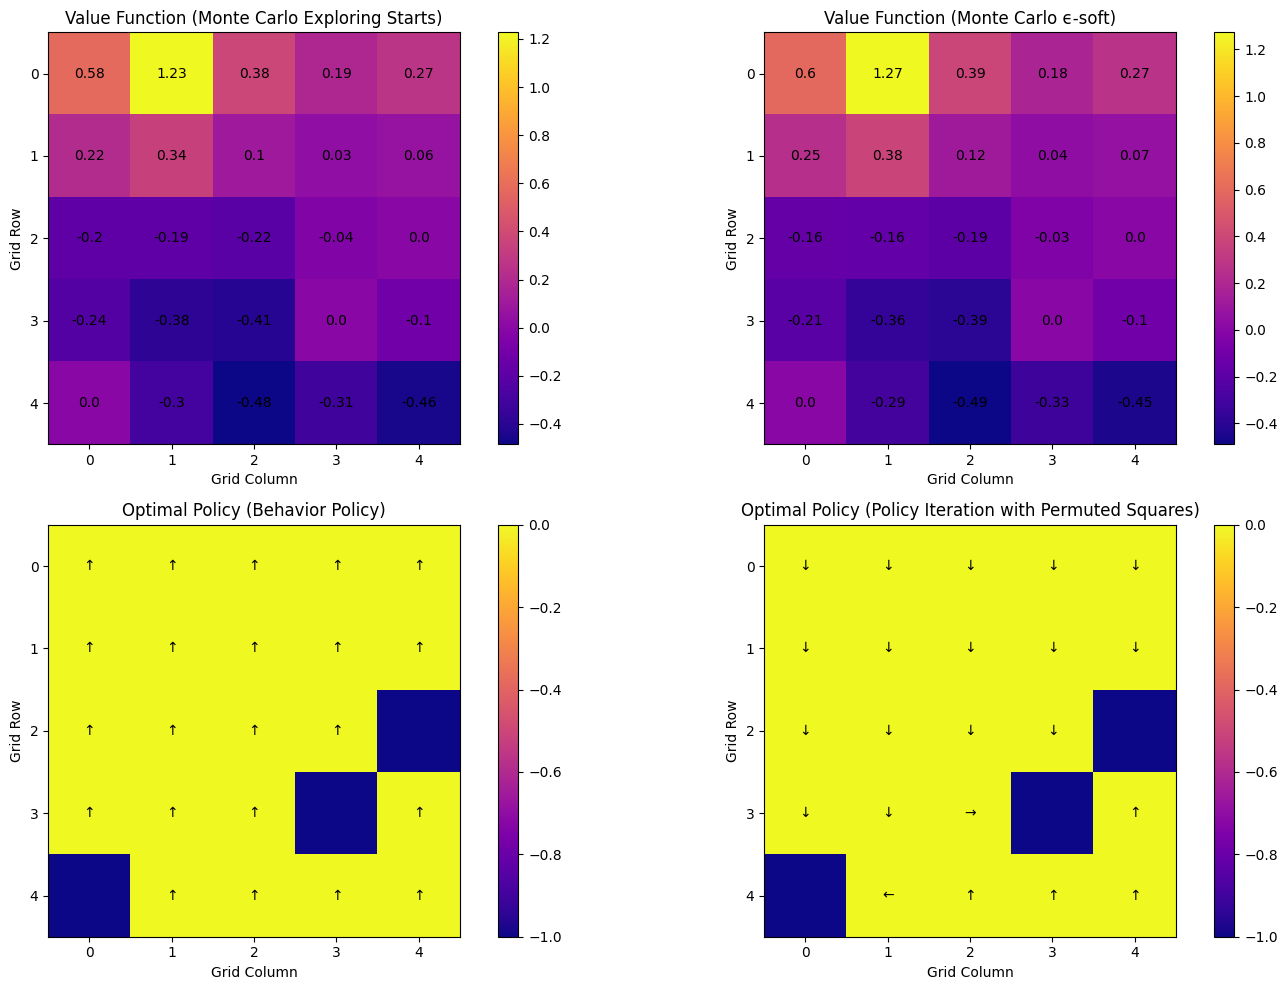

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt

# Plotting function for value functions
def plot_value_function(ax, V, title):
    cax = ax.imshow(V, cmap='plasma', interpolation='nearest')
    ax.set_title(title)
    ax.set_xlabel('Grid Column')
    ax.set_ylabel('Grid Row')
    for i in range(V.shape[0]):
        for j in range(V.shape[1]):
            ax.text(j, i, round(V[i, j], 2), ha='center', va='center', color='black')
    return cax

# Plotting function for policies
def plot_policy(ax, policy, title):
    grid = np.zeros((grid_size, grid_size))
    for i in range(grid_size):
        for j in range(grid_size):
            if is_terminal((i, j)):
                grid[i, j] = -1  # Mark terminal states
    cax = ax.imshow(grid, cmap='plasma', interpolation='nearest')
    ax.set_title(title)
    ax.set_xlabel('Grid Column')
    ax.set_ylabel('Grid Row')

    actions = ['↑', '↓', '←', '→']
    for i in range(grid_size):
        for j in range(grid_size):
            if not is_terminal((i, j)):
                best_action = np.argmax(policy[i, j])
                ax.text(j, i, actions[best_action], ha='center', va='center', color='black')
    return cax

# monte_carlo_es, monte_carlo_epsilon_soft, behaviour_policy, policy_iteration_permuted
# grid_size, rewards, gamma, episodes, epsilon, is_terminal

# Monte Carlo with Exploring Starts
V_es = monte_carlo_es(lambda s: random.choice(['up', 'down', 'left', 'right']), np.zeros((grid_size, grid_size)), rewards, gamma, episodes)

# Monte Carlo with ϵ-soft Policy
def random_policy(state):
    return random.choice(['up', 'down', 'left', 'right'])  # Ensure policy always returns a valid action

V_eps_soft = monte_carlo_epsilon_soft(random_policy, np.zeros((grid_size, grid_size)), rewards, gamma, epsilon, episodes)

# Behavior Policy with Equiprobable Moves
policy_behavior = behaviour_policy(grid_size, episodes, gamma)

# Policy Iteration with Permuted Squares
policy_permuted = policy_iteration_permuted(grid_size, 100, gamma)

# Create a figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot each grid with the new plot function
cax1 = plot_value_function(axes[0, 0], V_es, "Value Function (Monte Carlo Exploring Starts)")
cax2 = plot_value_function(axes[0, 1], V_eps_soft, "Value Function (Monte Carlo ϵ-soft)")
cax3 = plot_policy(axes[1, 0], policy_behavior, "Optimal Policy (Behavior Policy)")
cax4 = plot_policy(axes[1, 1], policy_permuted, "Optimal Policy (Policy Iteration with Permuted Squares)")

# Add colorbars to each subplot
fig.colorbar(cax1, ax=axes[0, 0])
fig.colorbar(cax2, ax=axes[0, 1])
fig.colorbar(cax3, ax=axes[1, 0])
fig.colorbar(cax4, ax=axes[1, 1])

# Adjust layout and display the plot
plt.tight_layout()
plt.show()